In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter, ParameterVector
from qiskit.synthesis import SuzukiTrotter


/home/ssr/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


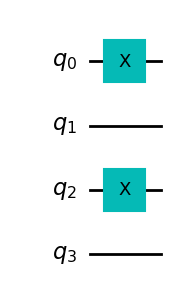

In [3]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()

# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals

# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op() # This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)

# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

HartreeFock_initial = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

HartreeFock_initial.draw('mpl')

#evo_time = Parameter('t')



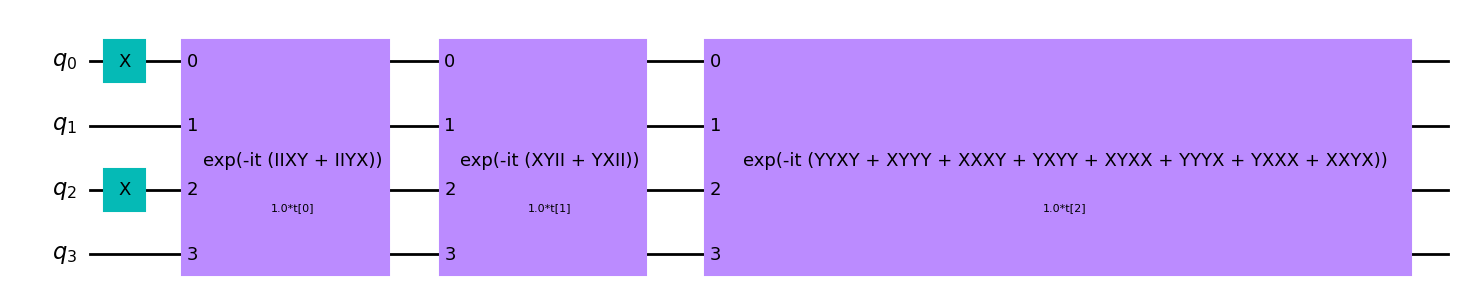

In [10]:
h2_ansatz = UCCSD(
    diHydro_prob.num_spatial_orbitals,
    diHydro_prob.num_particles,
    jw_map,
    initial_state=HartreeFock_initial,
)

h2_ansatz.decompose().draw('mpl')

[-1.83696799]
[-0.91386086]
[-1.4526317]
[-1.8190901]
[-0.63399445]
[-1.58193236]
[-1.70644896]
[-0.55479296]
[-1.73122792]
[-1.5680254]
[-0.70666048]
[-1.83530538]
[-1.45291094]
[-1.02838208]
[-1.81840908]
[-1.38050061]
[-1.39798526]
[-1.6357977]
[-1.35286436]
[-1.69094654]
[-1.3099308]
[-1.37234186]
[-1.8334609]
[-0.93582995]
[-1.44613217]
[-1.82371505]
[-0.64641779]
[-1.5727471]
[-1.71491133]
[-0.55280944]
[-1.72241587]
[-1.57634863]
[-0.69114423]
[-1.83162007]
[-1.45892952]
[-1.00545754]
[-1.82414171]
[-1.38370844]
[-1.37600215]
[-1.65203962]
[-1.3532708]
[-1.6766345]
[-1.33300096]
[-1.36960663]
[-1.82933993]
[-0.95813736]
[-1.43984892]
[-1.82794793]
[-0.65963235]
[-1.56366416]
[-1.72326451]
[-0.55176437]
[-1.71345081]
[-1.58476528]
[-0.67633776]
[-1.82746946]
[-1.46511929]
[-0.98275467]
[-1.82920832]
[-1.38709085]
[-1.35372872]
[-1.66768159]
[-1.35385743]
[-1.66171923]
[-1.35583836]
[-1.3670841]
[-1.82459717]
[-0.98074918]
[-1.43378449]
[-1.83177127]
[-0.67361706]
[-1.55469508]
[-

Text(0.5, 1.0, 'Energy over time')

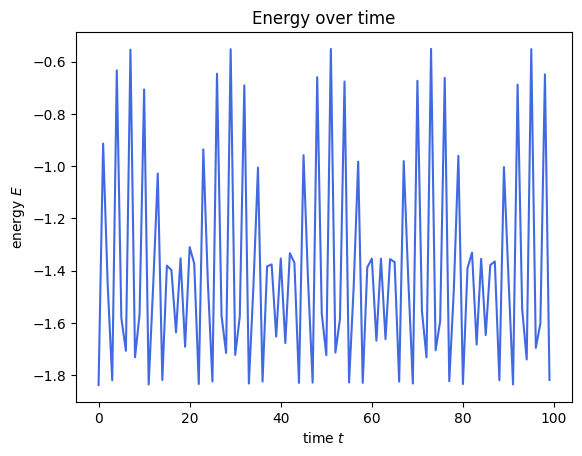

In [19]:
# Invoke appropriate ansatz for a Vartiational Time evolution algorithm:

from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.time_evolvers.variational import RealMcLachlanPrinciple

# Invoke estimator again, in addition to setting up list for values:

estimator = Estimator()
var_energies = list()
#standard_circs = list()

h2_ansatz = UCCSD(
    diHydro_prob.num_spatial_orbitals,
    diHydro_prob.num_particles,
    jw_map,
    initial_state=HartreeFock_initial,
)

# Create a time range for the evolution using standard tools:

standard_evo_time_range_h2 = np.arange(0, 100, 1)

# Initiate the parameters for the ansatz: 

init_param_values = np.zeros(len(h2_ansatz.parameters))

for i in range(len(h2_ansatz.parameters)):
    init_param_values[i] = 3

var_principle = RealMcLachlanPrinciple()

ansatz_circ = h2_ansatz.parameters

for k in range(len(standard_evo_time_range_h2)):

    # Invoke the TimeEvolutionProblem to create a problem instance for an evolver:

    var_problem = VarQRTE(h2_ansatz, [standard_evo_time_range_h2[k], standard_evo_time_range_h2[k], standard_evo_time_range_h2[k]], var_principle, num_timesteps=0.1)

    standard_problem = TimeEvolutionProblem(qubit_h2_Ham, time=1) # Create the TimeEvolutionProblem on the Dihydrogen Qubit Hamiltonian.

    # Invoke the SciPyRealEvolver to create a TimeEvolutionResult instance:

    #SciPy = SciPyRealEvolver(1)

    # Evolve the Dihydrogen Hamiltonian with respect to the initial Hartree-Fock State:

    #standard_result = SciPy.evolve(standard_problem)

    var_result = var_problem.evolve(standard_problem)

    var_circ = var_result.evolved_state

    estimator_result = estimator.run(var_circ, qubit_h2_Ham, None).result()

    #standard_state = standard_result.evolved_state

    #var_result = estimator.run(var_state, qubit_h2_Ham, None).result()

    #standard_result = standard_state.expectation_value(qubit_h2_Ham)

    print(estimator_result.values)

    var_energies.append(estimator_result.values)


#print(np.real(standard_energies))

#print(standard_result)

# Graph the resulting real time evolution of the system:

#energies = estimator.run(standard_result, qubit_h2_Ham).result().values

plt.plot(standard_evo_time_range_h2, var_energies, color="royalblue")
plt.xlabel("time $t$")
plt.ylabel("energy $E$")
plt.title("Energy over time")